In [179]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

In [180]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [181]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import scSpaMet as spamet

In [183]:
experiment = "lung"
cores = ["B5", "C6", "D4", "E4", "E6", "F4", "F7"]
datasets = [core + f"_{i}" for i in range(1, 5) for core in cores]

# Load data

In [184]:
from sklearn.preprocessing import MinMaxScaler

def read_props(dataset):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{dataset}.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [185]:
adatas = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(
            "_".join([experiment, dataset])
        )
    except:
        continue
    # Normalize
    df_intensity_TS.drop(["Total", "Rest"], axis=1, inplace=True)
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    pseudo_count=0.1
    data_all = df_intensity_TS.iloc[:, 1:].values
    data_all_norm = (data_all+pseudo_count)/(np.percentile(data_all,50,axis=1,keepdims=True)+pseudo_count)
    data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_IMC.merge(df_intensity_TS, on="Id")
    df.set_index("Id", inplace=True)
    
    # Put to adata format
    adata = sc.AnnData(df.values, dtype=df.values.dtype)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    adatas.append(adata)

adata = ad.concat(adatas, join="inner")

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [186]:
adata

AnnData object with n_obs × n_vars = 18560 × 211
    obs: 'Cell', 'Dataset', 'Core'
    obsm: 'spatial'

In [187]:
# Define IMC and SIMS marker list
IMC_markers = df_intensity_IMC.columns.tolist()[1:]
SIMS_masses = df_intensity_TS.columns.tolist()[1:]

# Drop markers
drop_list = ['MHCII', "CD11b", "CD11c", "DNA1", "DNA2", "HistoneH3"]
IMC_markers = [m for m in IMC_markers if m not in drop_list]

# Joint embedding

In [188]:
def Umap(a,rep=None):
    if rep is not None:
        print(f'Using representation {rep}')
        sc.pp.neighbors(a,use_rep=rep)
    else:
        sc.pp.neighbors(a)
    sc.tl.umap(a)
    print('Sucessfully run Umap!')
    return a

In [189]:
all_list = np.concatenate([SIMS_masses, IMC_markers])

In [190]:
adata_joint = adata[:, all_list]
train_x = adata_joint.X

In [191]:
X_embedding = spamet.tl.Joint_VAE(train_x, epochs=200)

GPU name:  []
Epoch 1/200
580/580 - 1s - loss: 0.5783 - reconstruction_loss: 0.5782 - kl_loss: 5.7401e-04 - 1s/epoch - 2ms/step
Epoch 2/200
580/580 - 1s - loss: 0.5732 - reconstruction_loss: 0.5732 - kl_loss: 5.3736e-06 - 922ms/epoch - 2ms/step
Epoch 3/200
580/580 - 1s - loss: 0.5728 - reconstruction_loss: 0.5728 - kl_loss: 2.4375e-06 - 903ms/epoch - 2ms/step
Epoch 4/200
580/580 - 1s - loss: 0.5727 - reconstruction_loss: 0.5727 - kl_loss: 1.4399e-06 - 939ms/epoch - 2ms/step
Epoch 5/200
580/580 - 1s - loss: 0.5727 - reconstruction_loss: 0.5727 - kl_loss: 1.0692e-06 - 907ms/epoch - 2ms/step
Epoch 6/200
580/580 - 1s - loss: 0.5726 - reconstruction_loss: 0.5726 - kl_loss: 1.1938e-06 - 913ms/epoch - 2ms/step
Epoch 7/200
580/580 - 1s - loss: 0.5726 - reconstruction_loss: 0.5726 - kl_loss: 1.3444e-06 - 901ms/epoch - 2ms/step
Epoch 8/200
580/580 - 1s - loss: 0.5726 - reconstruction_loss: 0.5726 - kl_loss: 9.9175e-07 - 903ms/epoch - 2ms/step
Epoch 9/200
580/580 - 1s - loss: 0.5726 - reconstruct

In [192]:
adata.obsm['Joint'] = X_embedding

In [193]:
Umap(adata,rep='Joint')

Using representation Joint
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:25)
Sucessfully run Umap!


AnnData object with n_obs × n_vars = 18560 × 211
    obs: 'Cell', 'Dataset', 'Core'
    uns: 'neighbors', 'umap'
    obsm: 'spatial', 'Joint', 'X_umap'
    obsp: 'distances', 'connectivities'

In [194]:
sc.tl.leiden(adata, resolution=0.25, random_state=0)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


# Viz

In [195]:
IMC_markers

['CD20',
 'CD3',
 'CD31',
 'CD4',
 'CD44',
 'CD45RA',
 'CD45RO',
 'CD68',
 'CD8',
 'COL1',
 'ECadherin',
 'FoxP3',
 'GranzymeB',
 'Ki67',
 'PanKeratin',
 'SMA',
 'Vimentin']

In [196]:
adata_IMC = adata[:, IMC_markers]


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\new_codex\lib\contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


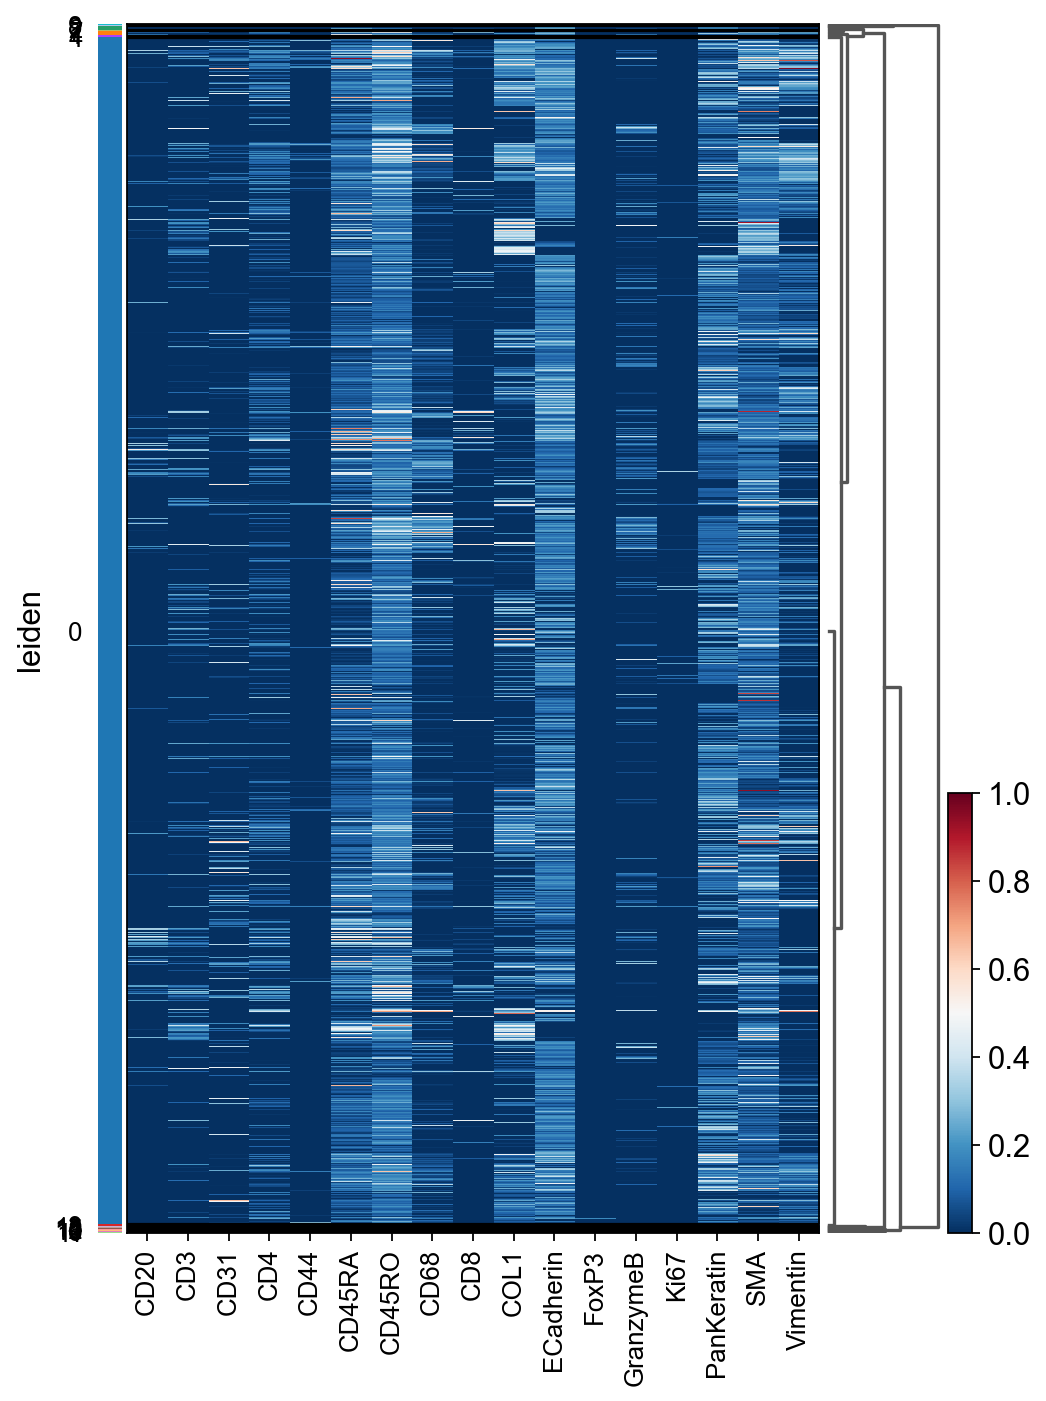

In [197]:
sc.pl.heatmap(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "leiden",
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 10),
)

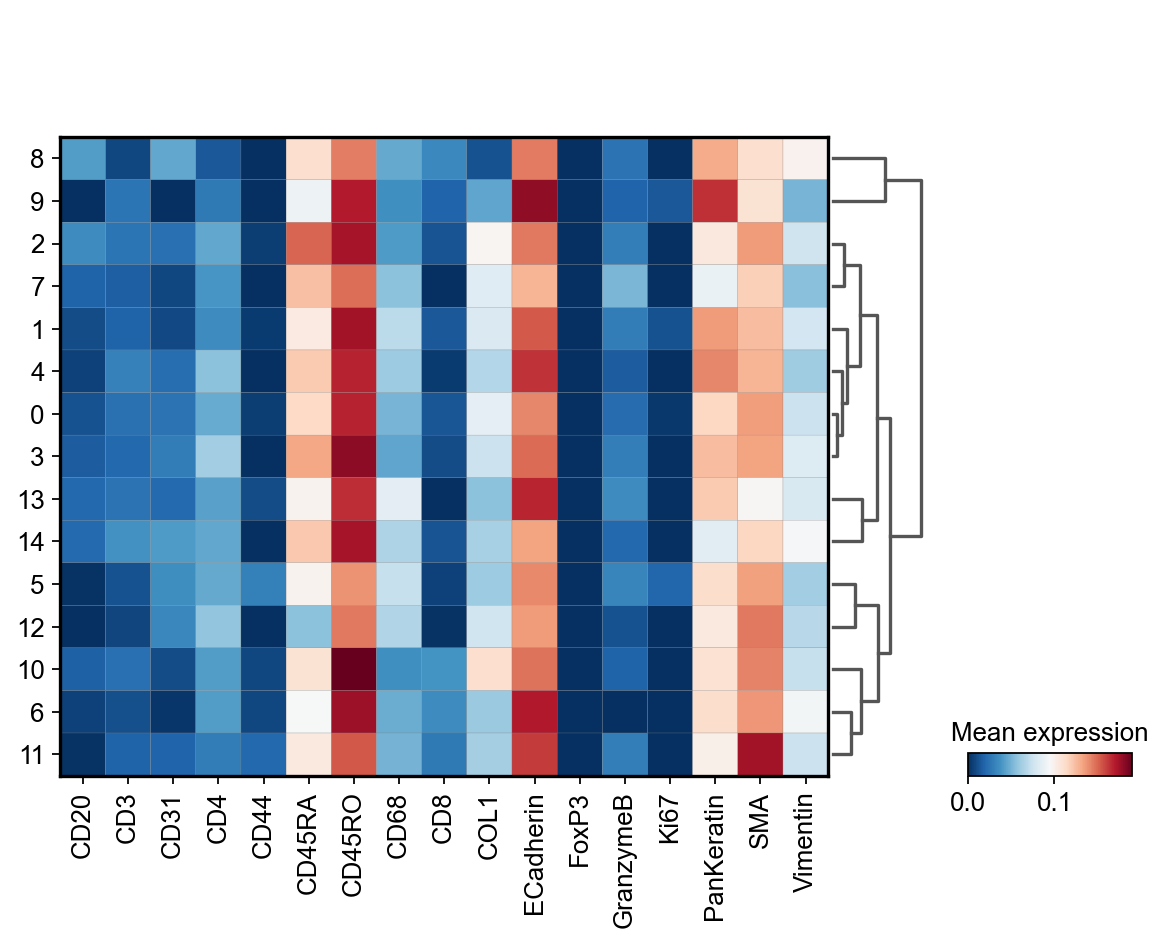

In [198]:
sc.pl.matrixplot(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "leiden",
    dendrogram=True,
    colorbar_title="Mean expression",
    cmap="RdBu_r",
)

In [199]:
adata_IMC

AnnData object with n_obs × n_vars = 18560 × 17
    obs: 'Cell', 'Dataset', 'Core', 'leiden'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors', 'dendrogram_leiden'
    obsm: 'spatial', 'Joint', 'X_umap'
    obsp: 'distances', 'connectivities'

# Plot masks

In [200]:
import matplotlib
import skimage


# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img

In [201]:
masks = get_masks(data_dir / "masks")

In [202]:
colors = adata_IMC.uns["leiden_colors"]
labels = np.unique(adata_IMC.obs.leiden.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

  0%|          | 0/15 [00:00<?, ?it/s]

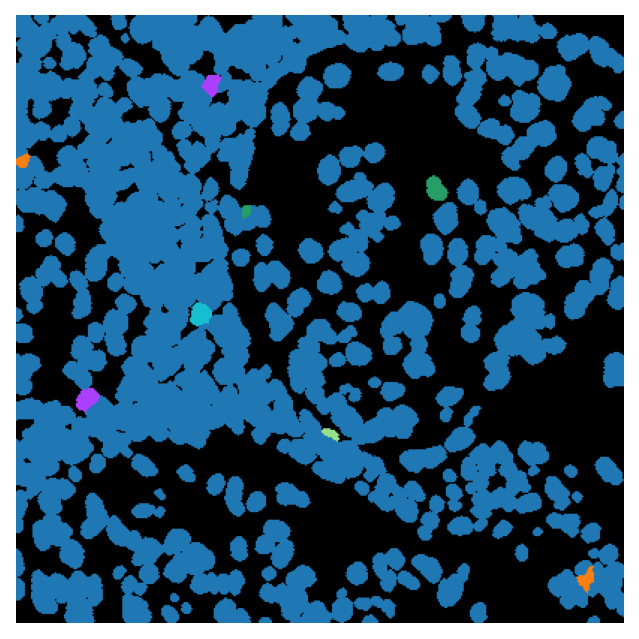

  0%|          | 0/15 [00:00<?, ?it/s]

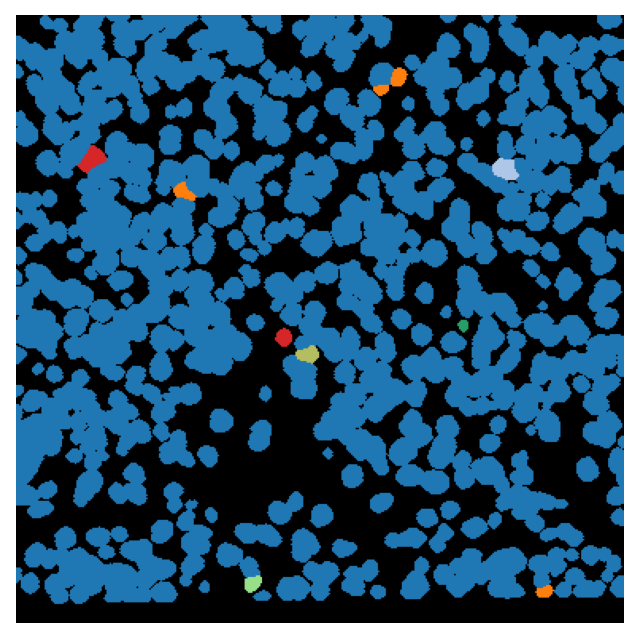

  0%|          | 0/15 [00:00<?, ?it/s]

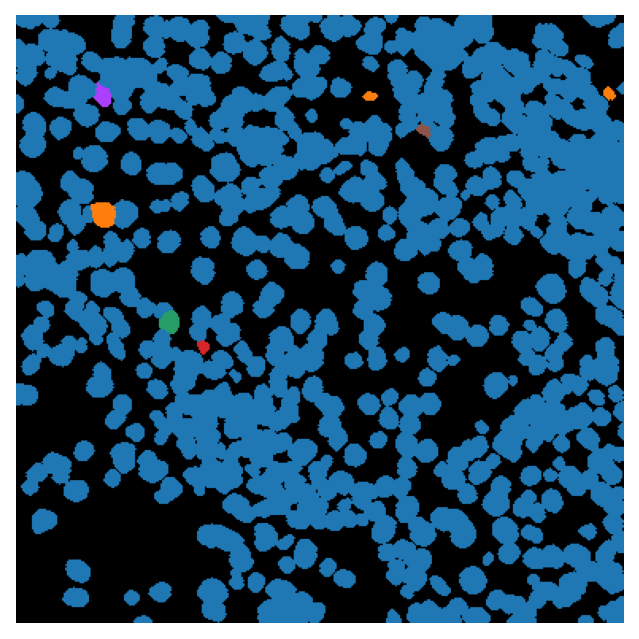

  0%|          | 0/15 [00:00<?, ?it/s]

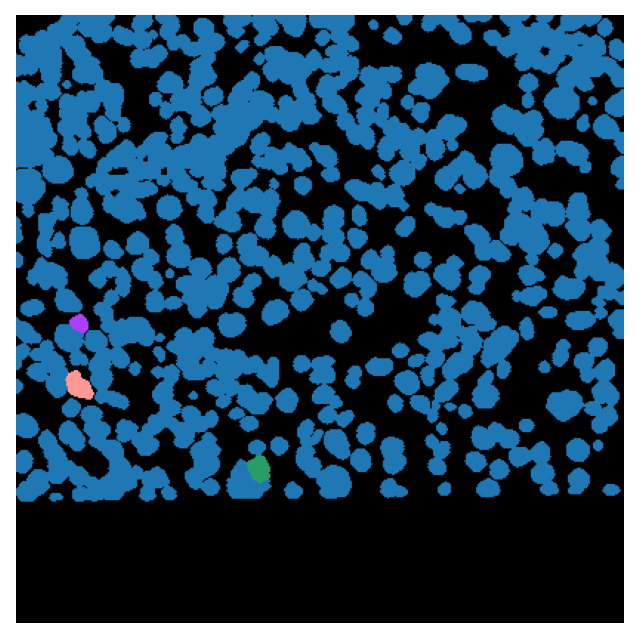

  0%|          | 0/15 [00:00<?, ?it/s]

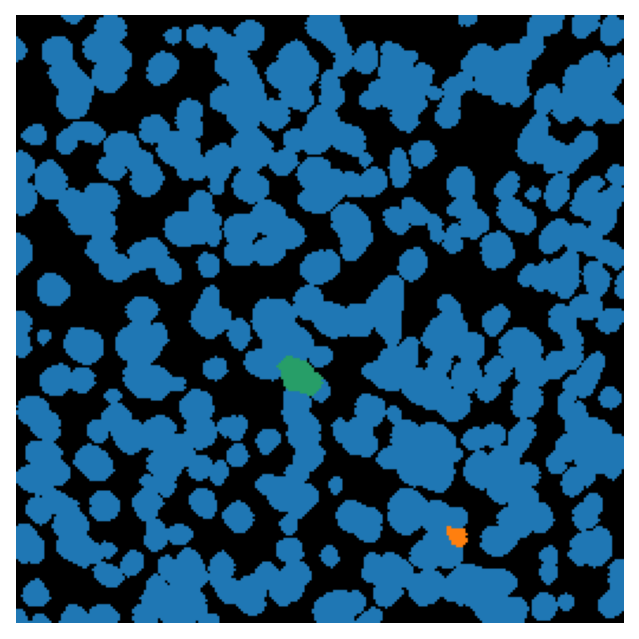

  0%|          | 0/15 [00:00<?, ?it/s]

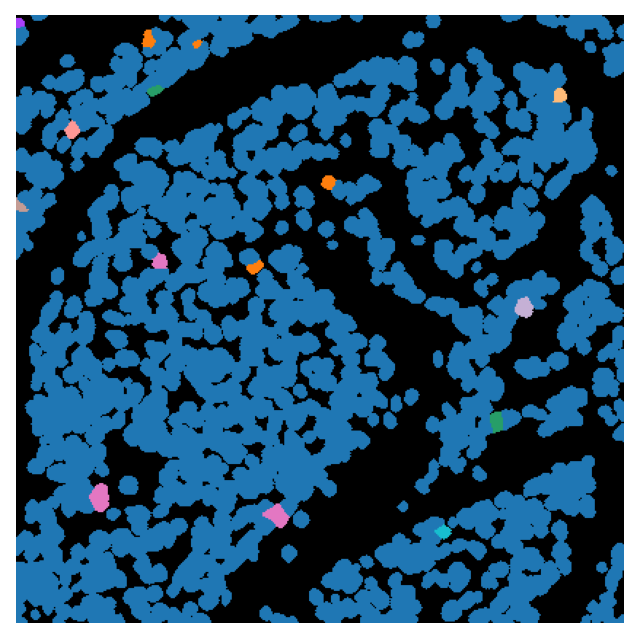

  0%|          | 0/15 [00:00<?, ?it/s]

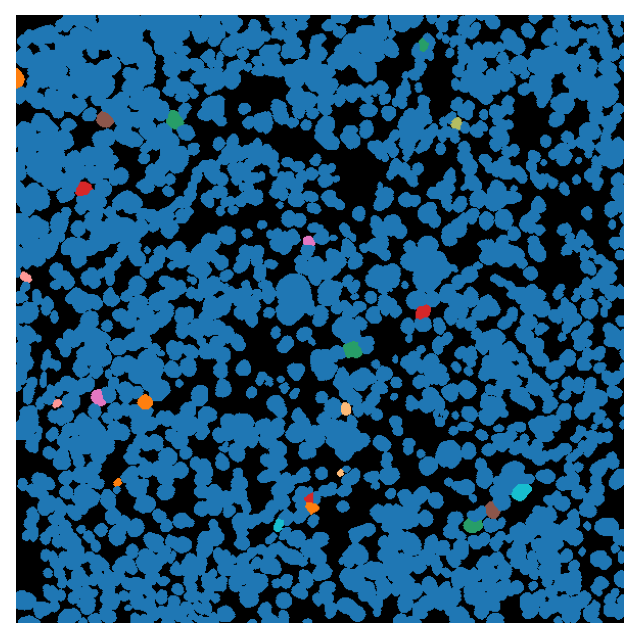

  0%|          | 0/15 [00:00<?, ?it/s]

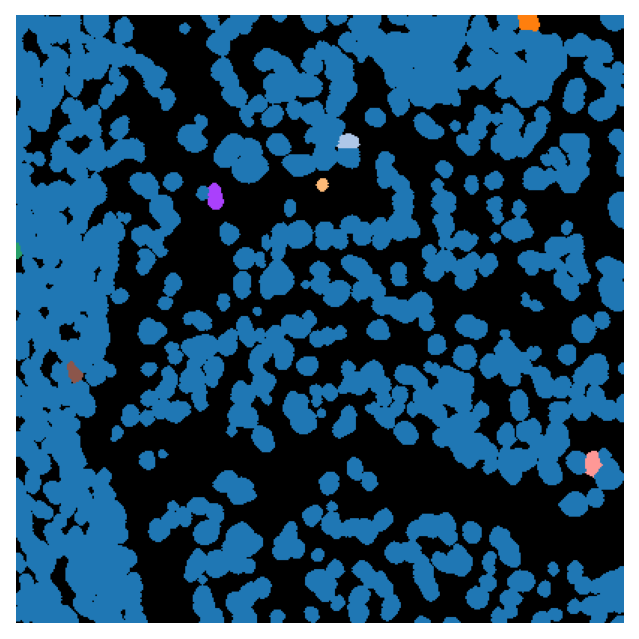

  0%|          | 0/15 [00:00<?, ?it/s]

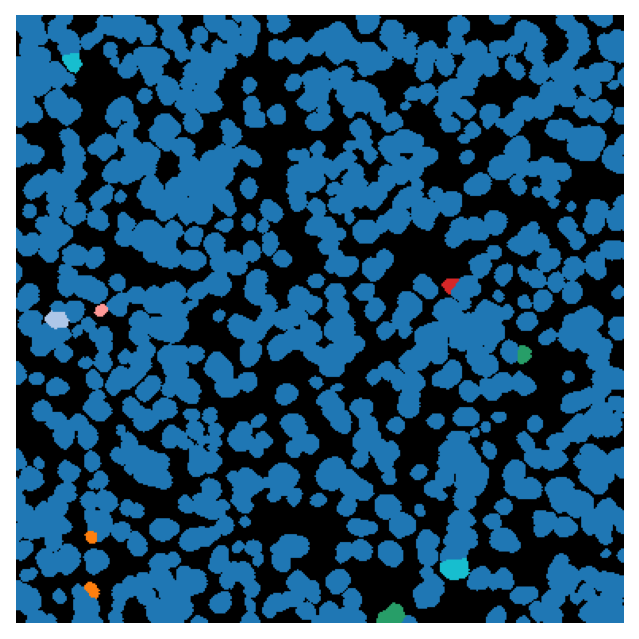

  0%|          | 0/15 [00:00<?, ?it/s]

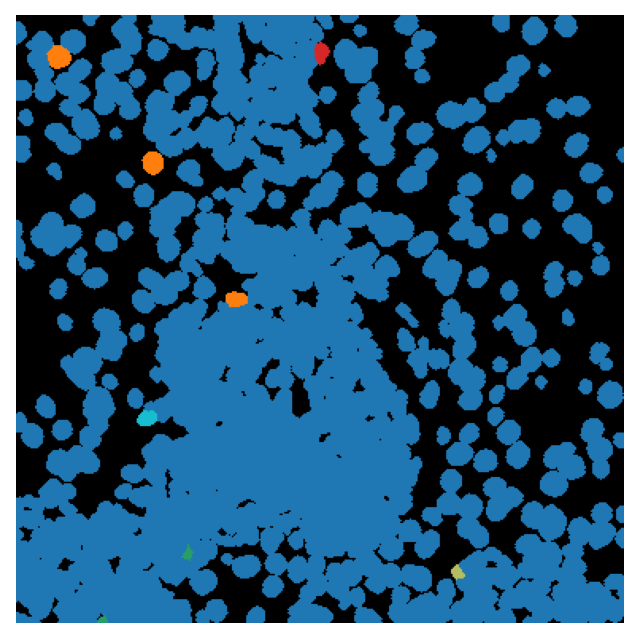

  0%|          | 0/15 [00:00<?, ?it/s]

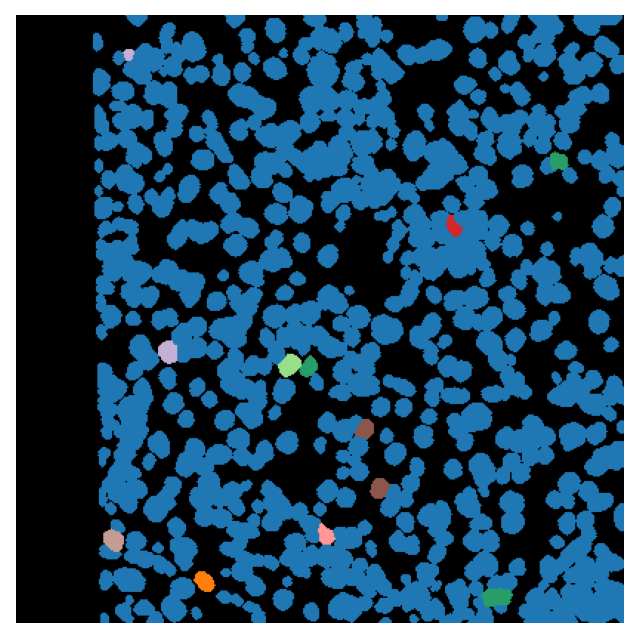

  0%|          | 0/15 [00:00<?, ?it/s]

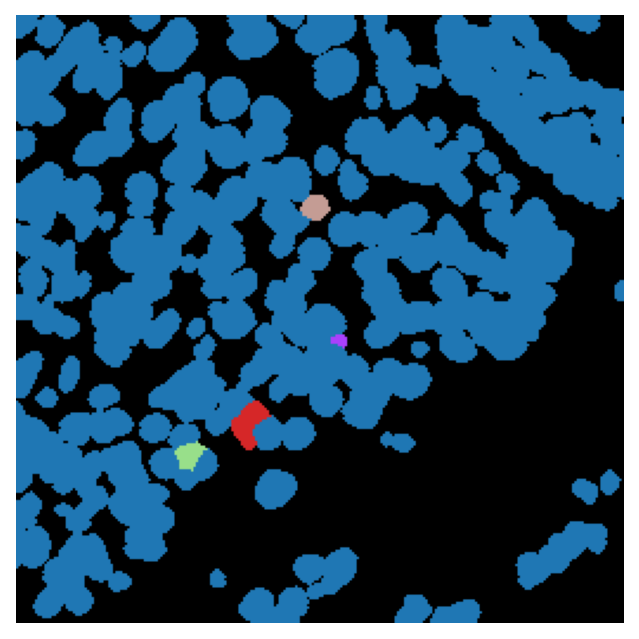

  0%|          | 0/15 [00:00<?, ?it/s]

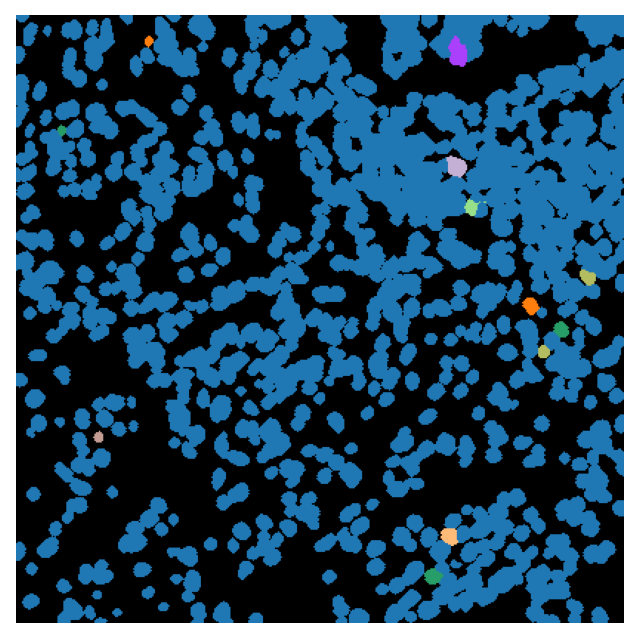

  0%|          | 0/15 [00:00<?, ?it/s]

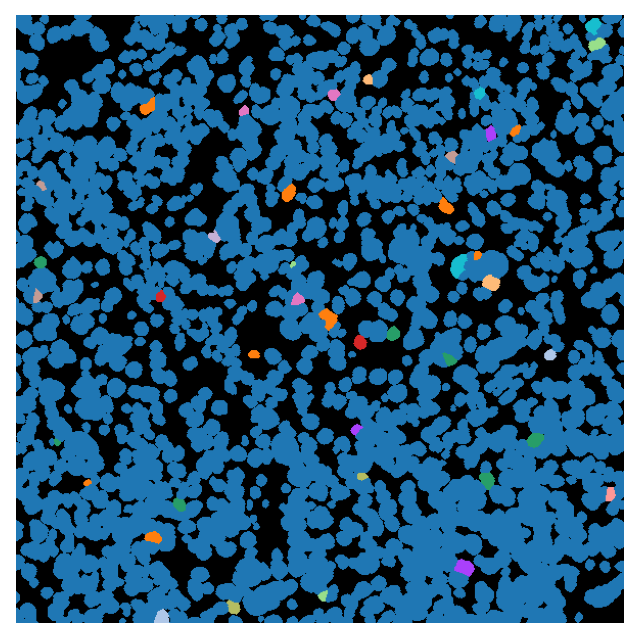

  0%|          | 0/15 [00:00<?, ?it/s]

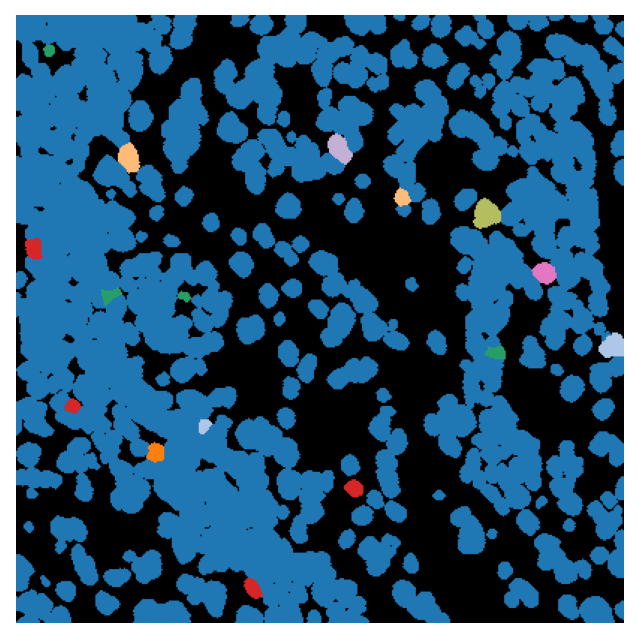

  0%|          | 0/15 [00:00<?, ?it/s]

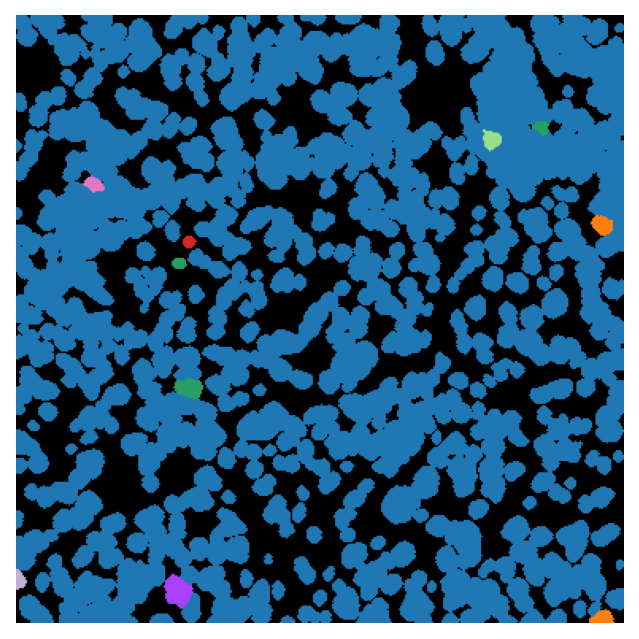

  0%|          | 0/15 [00:00<?, ?it/s]

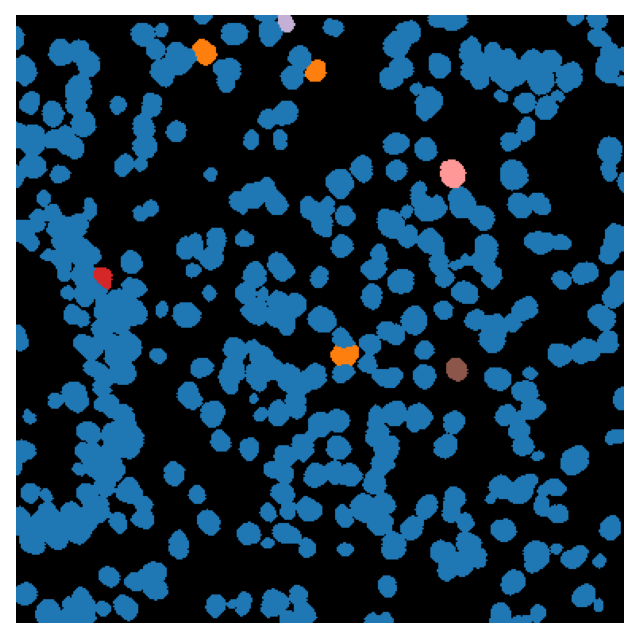

  0%|          | 0/15 [00:00<?, ?it/s]

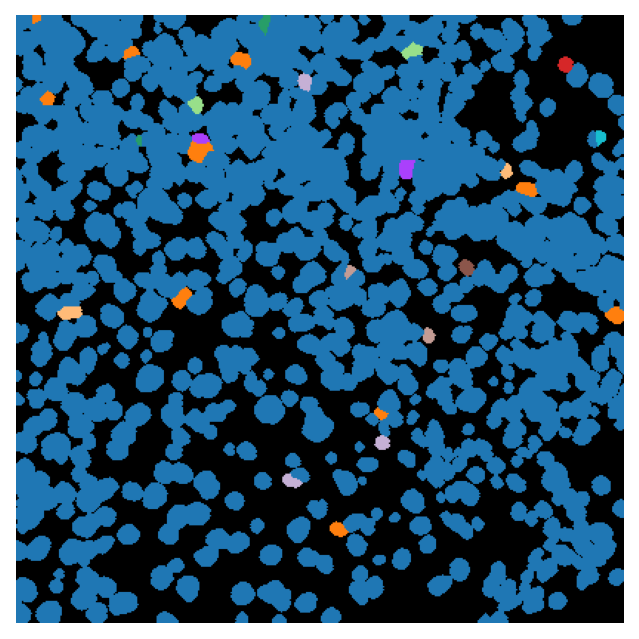

  0%|          | 0/15 [00:00<?, ?it/s]

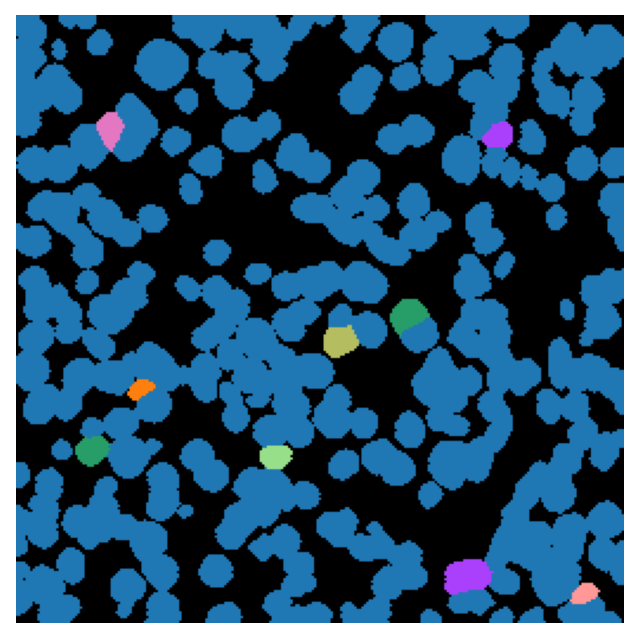

  0%|          | 0/15 [00:00<?, ?it/s]

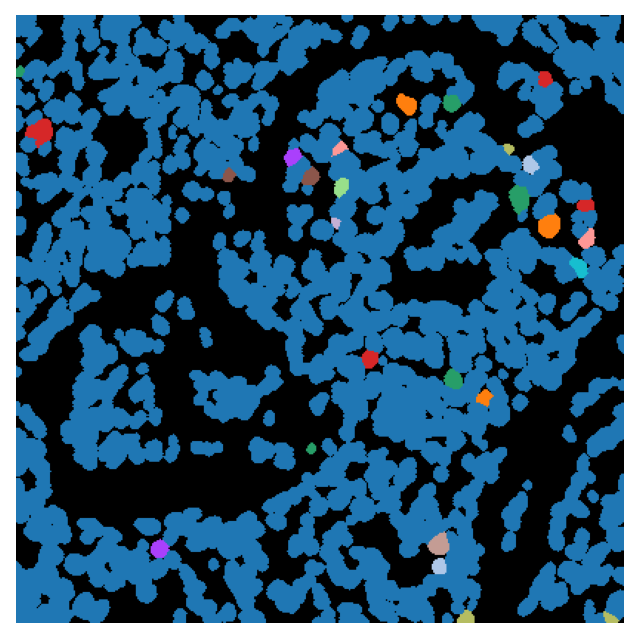

  0%|          | 0/15 [00:00<?, ?it/s]

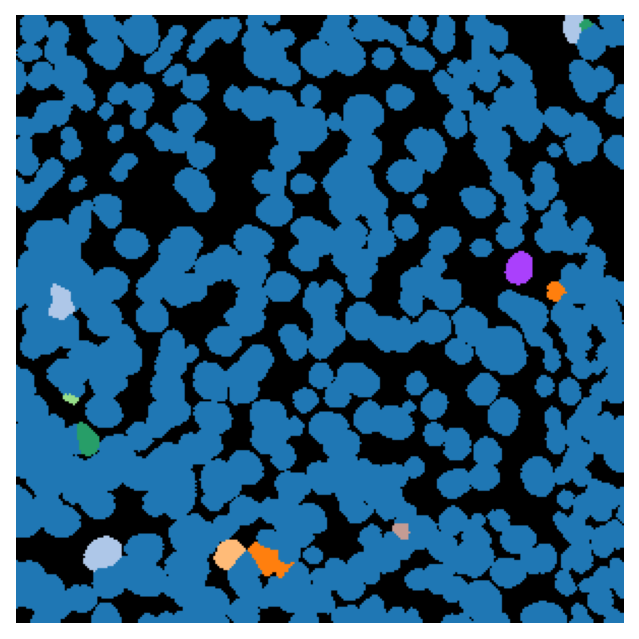

KeyError: 'Lung_B5_4'

In [203]:
experiment = 'Lung'

for dataset in datasets:
    adata_subset = adata_IMC[adata_IMC.obs.Dataset == dataset, :]
    mask = masks[experiment + '_' + dataset]

    # Get label2cell dict
    label2cell = {}
    for l in labels:
        cell_id = adata_subset[adata_subset.obs.leiden == l].obs.Cell.to_list()
        label2cell[l] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.axis("off")
    plt.show()